In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import numpy as np

import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

pio.renderers.default = "svg"

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
train_df.Type_of_Loan.nunique()

2011

In [ ]:
train_df.loc[[0,1,2,4]][["Customer_ID","Age","Monthly_Inhand_Salary"]]

,Customer_ID,Age,Monthly_Inhand_Salary
0,CUS_0xd40,23,1824.843333
1,CUS_0xd40,23,NaN
2,CUS_0xd40,-500,NaN
4,CUS_0xd40,23,1824.843333


#### El dataset tiene 100000 filas y 28 columnas

In [ ]:
train_df.shape

(100000, 28)

#### Datos Faltantes

In [ ]:
nas = train_df.isna().sum().to_frame()
nas.columns = ["Número Datos Faltantes"]
nas

,Número Datos Faltantes
ID,0
Customer_ID,0
Month,0
Name,9985
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


### EDA

In [ ]:
train_df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [ ]:
train_df.describe(exclude=np.number)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,100000,100000,100000,100000,100000,88592,92998,100000,100000,100000,90970,100000,95521,100000,98800,100000
unique,100000,12500,8,10139,1788,12501,16,18940,434,6260,749,4384,4,13178,404,3,91049,7,98792,3
top,0x1602,CUS_0xd40,January,Langep,38,#F%$D@*&8,_______,36585.12,3,Not Specified,19,_,Standard,1360.45,15 Years and 11 Months,Yes,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12500,44,2833,5572,7062,16,14386,1408,5327,2091,36479,24,446,52326,4305,25513,9,53174


Vemos que hay valores extraños. Por ejemplo en SSN el valor top es "#F%$D@*&8", también hay muchos valores en blanco o ______ problema que debe ser corregido.

In [ ]:
train_df = train_df.applymap(lambda x: x if x is np.NaN or not isinstance(x, str) else str(x).strip('_ ,"')).replace(['', 'nan', '!@9#%8', '#F%$D@*&8'], np.NaN)

Vemos que hay columnas que no vamos a utilizar por tener una cardinalidad muy alta como lo son ID, Name y SSN.

Luego debemos pasar los valores que son númericos pero se leyeron como "string" por los problemas de calidad.

In [ ]:
train_df['Age'] = train_df.Age.astype(int)   
train_df['SSN'] = train_df.SSN.apply(lambda x: x if x is np.NaN else float(str(x).replace('-', ''))).astype(float)
train_df['Annual_Income'] = train_df.Annual_Income.astype(float)
train_df['Num_of_Loan'] = train_df.Num_of_Loan.astype(int) 
train_df['Num_of_Delayed_Payment'] = train_df.Num_of_Delayed_Payment.astype(float)
train_df['Changed_Credit_Limit'] = train_df.Changed_Credit_Limit.astype(float)
train_df['Outstanding_Debt'] = train_df.Outstanding_Debt.astype(float)
train_df['Amount_invested_monthly'] = train_df.Amount_invested_monthly.astype(float)
train_df['Monthly_Balance'] = train_df.Monthly_Balance.astype(float)

In [ ]:
train_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821000265.0,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821000265.0,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good


  Notamos que la columna Credit_History_Age 
  es numerica pero está escrita en palabras. Para solucionarlo pasamos esta columna a meses.

In [ ]:
def meses(x):
    if pd.notnull(x):
        anios = int(x.split(' ')[0])
        meses = int(x.split(' ')[3])
      
        return anios*12+meses
    else:
        return x

In [ ]:
train_df['Credit_History_Age']  = train_df.Credit_History_Age.apply(lambda x: meses(x)).astype(float)

In [ ]:
object_columns=list(train_df.select_dtypes(include='object').columns)
num_columns = list(train_df.select_dtypes(include=["int64","float64"]).columns)

## Revisión y limpieza variables númericas

#### Age
Podemos ver que los valores de la columna Age no tienen sentido. Hay valores muy altos o negativos que no pueden ser edades.

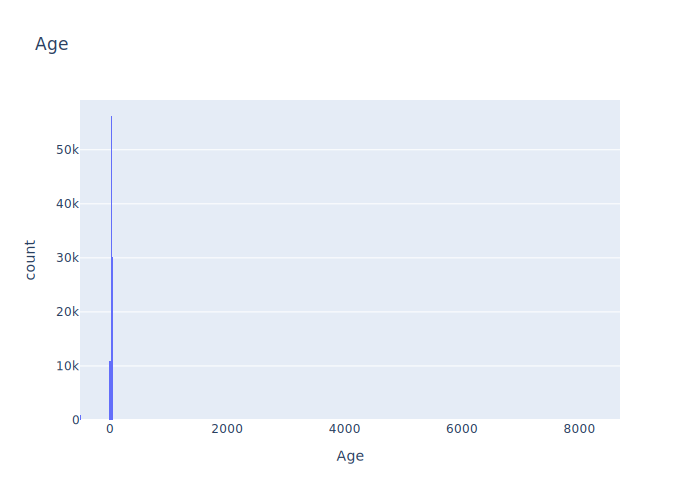

In [ ]:
fig = px.histogram(train_df, x="Age",title = "Age")
fig.show()

#### Limpieza Age

Al ver que hay varios datos para un mismo customer, cuando se encuentra un dato anomalo o NA se reemplazará por la moda de la edad de ese cliente especifico.

EJ:
En el caso mostrado abajo, este customer tiene un dato anomalo con edad de -500 pero podemos ver que en otros datos el mismo cliente tiene una edad de 23 por lo que el -500 será reemplazado por la moda que es este valor. No la media porque se considera que el valor que más se repite debe ser el más acertado. **Esto es un supuesto bastante fuerte y en un caso real debe ser validado con el negocio. **

In [ ]:
train_df[train_df.Customer_ID == "CUS_0xd40"]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821000265.0,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821000265.0,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821000265.0,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,270.0,No,49.574949,62.430172,NaN,340.479212,Good
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821000265.0,Scientist,19114.12,1824.843333,3,...,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
7,0x1609,CUS_0xd40,August,NaN,23,NaN,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,Standard


In [ ]:
def limpieza_age(row):
  if (90 <= row['Age']) or (0 > row['Age']) :
      Age=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Age'].dropna()).mode()
      try:
          return Age[0]
      except:
          return np.NaN
  else:
      return row['Age']

In [ ]:
train_df["Age"] = train_df.apply(limpieza_age,axis=1)

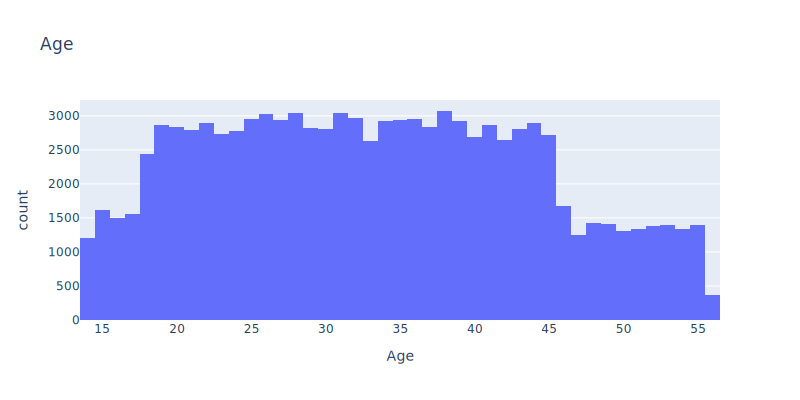

In [ ]:
fig = px.histogram(train_df, x="Age",title = "Age",width=800, height=400)
fig.show()

Las edades van desde los 14 hasta los 56 años. La mayoria de personas se encuentran entre los 20 y 45 años

#### Num_Bank_Accounts

Podemos ver que los valores de la columna Num_Bank_Accounts no tienen sentido. Hay valores negativos, y valores muy grandes que no tienen sentido en el contexto de negocio.
Utilizamos la misma metodología utilizada para la edad

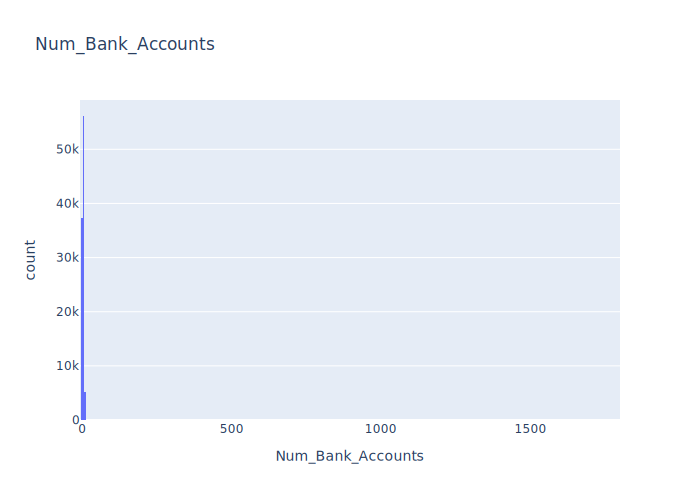

In [ ]:
fig = px.histogram(train_df, x="Num_Bank_Accounts",title = "Num_Bank_Accounts")
fig.show()

In [ ]:
def limpieza_bank(row):
  if 12 < row['Num_Bank_Accounts'] or 0 > row['Num_Bank_Accounts'] :
      Num_Bank_Accounts=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Num_Bank_Accounts'].dropna()).mode()
      try:
          return Num_Bank_Accounts[0]
      except:
          return np.NaN
  else:
      return row['Num_Bank_Accounts']

In [ ]:
train_df["Num_Bank_Accounts"] = train_df.apply(limpieza_bank,axis=1)
train_df = train_df[train_df.Num_Bank_Accounts >= 0]

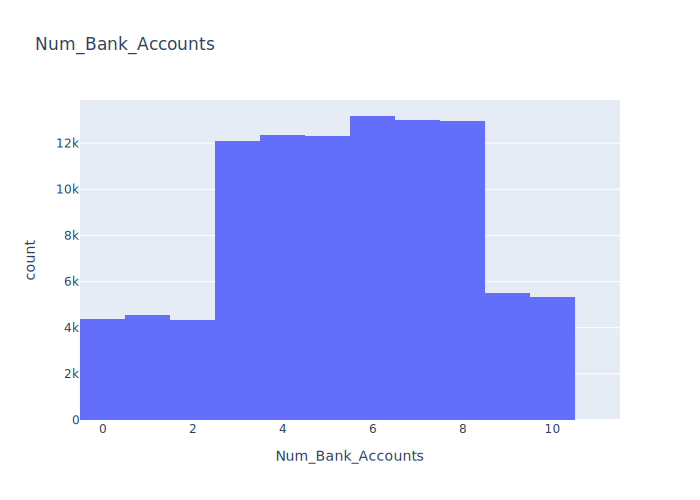

In [ ]:
fig = px.histogram(train_df, x="Num_Bank_Accounts",title = "Num_Bank_Accounts")
fig.show()

El número de cuentas bancarias va desde 0 hasta 10, la mayoria de personas tiene entre 3 y 8 cuentas bancarias

#### Num_Credit_Card
Podemos ver que los valores de la columna Num_Credit_Card no tienen sentido. Hay valores muy grandes que no tienen sentido en el contexto de negocio.
Realizamos el mismo procedimiento.
Se valida que también funcione esta metodología para este caso.

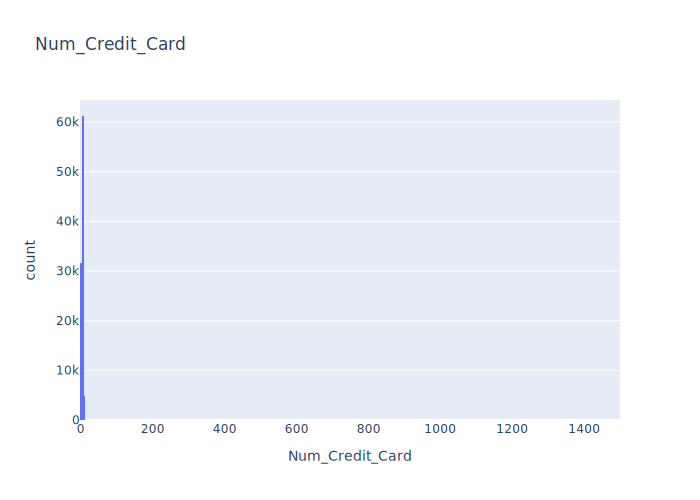

In [ ]:
fig = px.histogram(train_df, x="Num_Credit_Card",title = "Num_Credit_Card")
fig.show()


In [ ]:
train_df[(train_df.Num_Credit_Card < 0) | (train_df.Num_Credit_Card >= 14)].reset_index(drop = True).loc[[0]][["Customer_ID","Num_Credit_Card"]]

,Customer_ID,Num_Credit_Card
0,CUS_0x21b1,1385


Vemos que para el cliente con ID CUS_0x21b1 hay un valor que dice que tiene 1385 tarjetas de credito. Buscamos al cliente para ver si tiene otros registros.

In [ ]:
train_df[train_df.Customer_ID == "CUS_0x21b1"][["Num_Credit_Card"]]

,Num_Credit_Card
8,4
9,4
10,1385
11,4
12,4
13,4
14,4
15,4


Se identifica que el valor correcto debería ser 4.

In [ ]:
def limpieza_tarjetas(row):
  if (11 <= row['Num_Credit_Card']) or (0 >= row['Num_Credit_Card']) :
      Num_Credit_Card=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Num_Credit_Card'].dropna()).mode()
      try:
          return Num_Credit_Card[0]
      except:
          return np.NaN
  else:
      return row['Num_Credit_Card']

In [ ]:
train_df["Num_Credit_Card"] = train_df.apply(limpieza_tarjetas,axis=1)

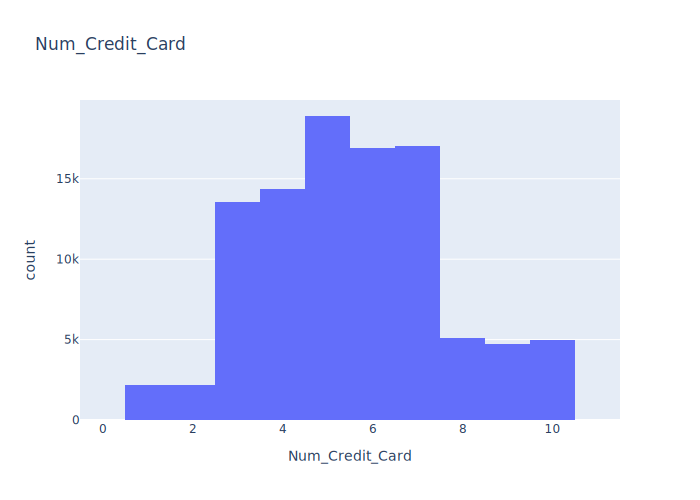

In [ ]:
fig = px.histogram(train_df, x="Num_Credit_Card",title = "Num_Credit_Card")
fig.show()

El número de tarjetas de credito va de 0 hasta 10, la mayoria de personas tienen entre 3 y 6 tarjetas

#### Interest_Rate	
Podemos ver que los valores de la columna Num_Bank_Accounts no tienen sentido. Hay valores muy grandes que no tienen sentido en el contexto de negocio.

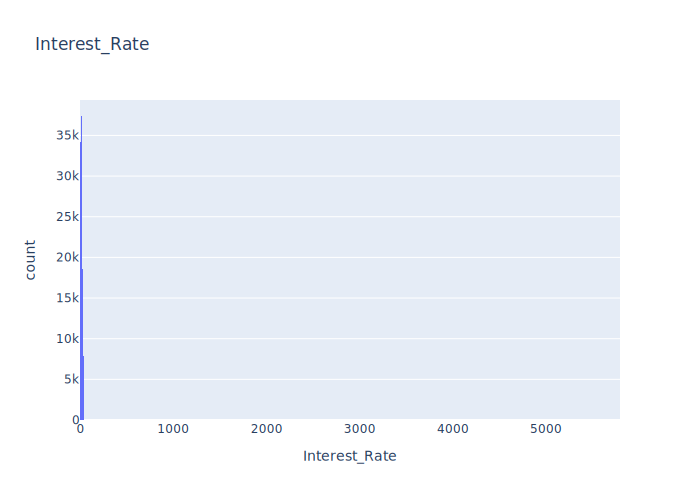

In [ ]:
fig = px.histogram(train_df, x="Interest_Rate",title = "Interest_Rate")
fig.show()


In [ ]:
def limpieza_tasa(row):
  if 30 < row['Interest_Rate'] :
      Interest_Rate=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Interest_Rate'].dropna()).mode()
      try:
          return Interest_Rate[0]
      except:
          return np.NaN
  else:
      return row['Interest_Rate']

In [ ]:
train_df['Interest_Rate']=train_df.apply(limpieza_tasa,axis=1)

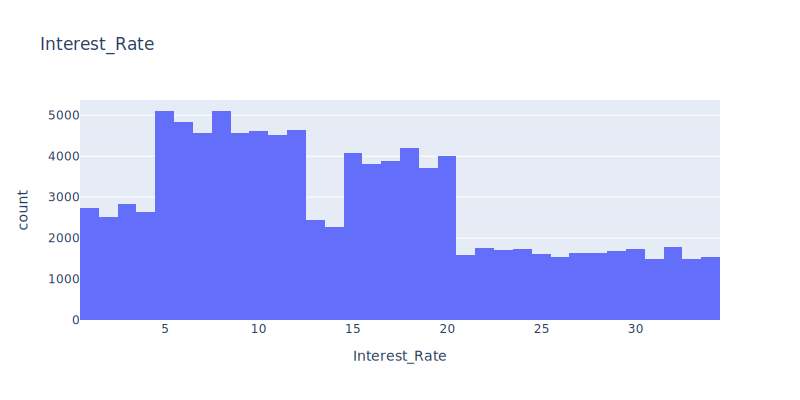

In [ ]:
fig = px.histogram(train_df, x="Interest_Rate",title = "Interest_Rate",width=800, height=400)
fig.show()

Las tasas de interes van desde el 1% hasta 34%. Hay picos entre el 5% y el 10% y el 15% y el 20%.

### Delay_from_due_date

Tiene valores negativos lo que no se debe permitir. Al ser tan pocos, se decide eliminarlos.

In [ ]:
train_df[(train_df.Delay_from_due_date <0)].shape

(591, 28)

In [ ]:
train_df = train_df[(train_df.Delay_from_due_date >=0)]

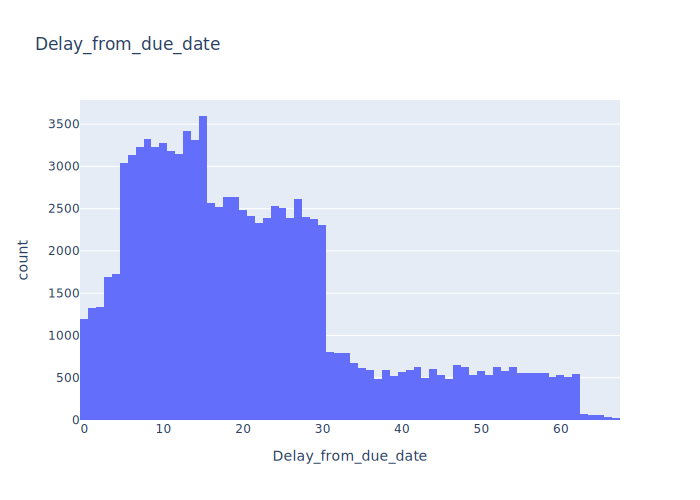

In [ ]:
fig = px.histogram(train_df, x="Delay_from_due_date",title = "Delay_from_due_date")
fig.show()

La mayoria de personas tienen un delay para pagar de entre 5 y 30 días

### Num_Credit_Inquiries

Tiene valores muy grandes

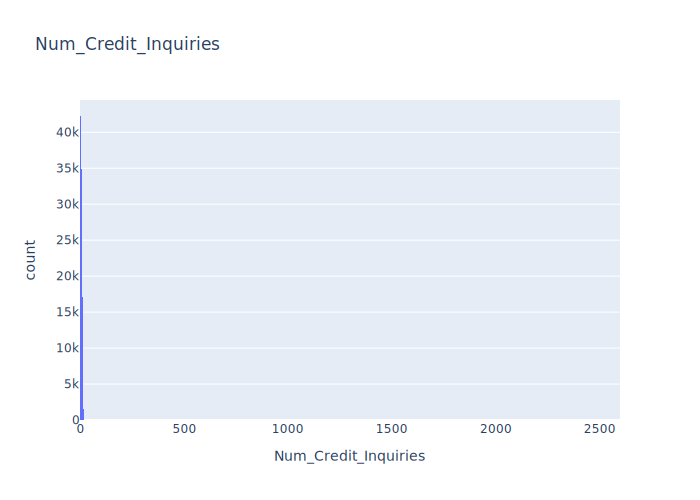

In [ ]:
fig = px.histogram(train_df, x="Num_Credit_Inquiries",title = "Num_Credit_Inquiries")
fig.show()

Realizamos el mismo procedimiento

In [ ]:
def limpieza_busquedas(row):
  if pd.isnull(row['Num_Credit_Inquiries']) or  row['Num_Credit_Inquiries'] > 20:
      Num_Credit_Inquiries=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Num_Credit_Inquiries'].dropna()).mode()
      try:
          return Num_Credit_Inquiries[0]
      except:
          return np.NaN
  else:
      return row['Num_Credit_Inquiries']

In [ ]:
train_df['Num_Credit_Inquiries'] = train_df.apply(limpieza_busquedas,axis=1)

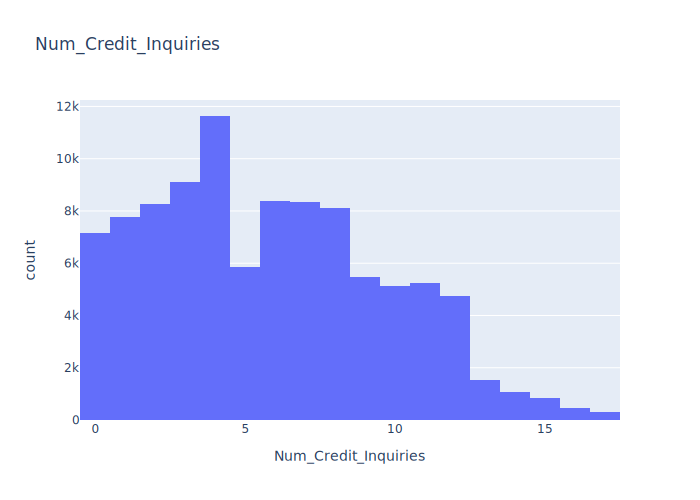

In [ ]:
fig = px.histogram(train_df, x="Num_Credit_Inquiries",title = "Num_Credit_Inquiries")
fig.show()

a la mayoria de personas la consultan entre 0 y 12 veces

### Credit_utilization_ratio

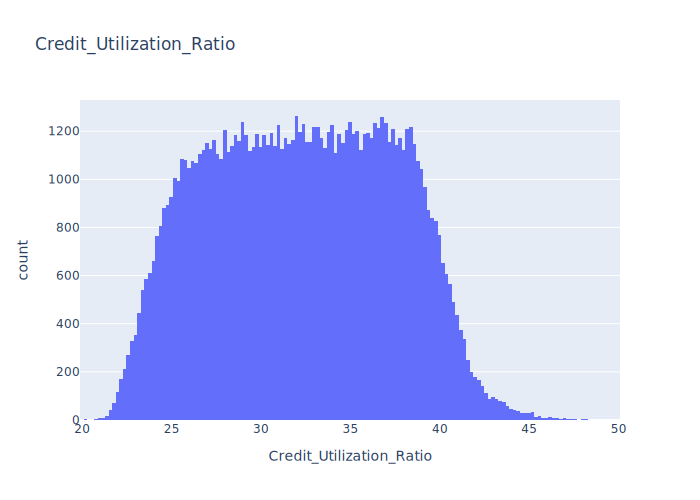

In [ ]:
fig = px.histogram(train_df, x="Credit_Utilization_Ratio",title = "Credit_Utilization_Ratio	")
fig.show()

### Total_EMI_per_month

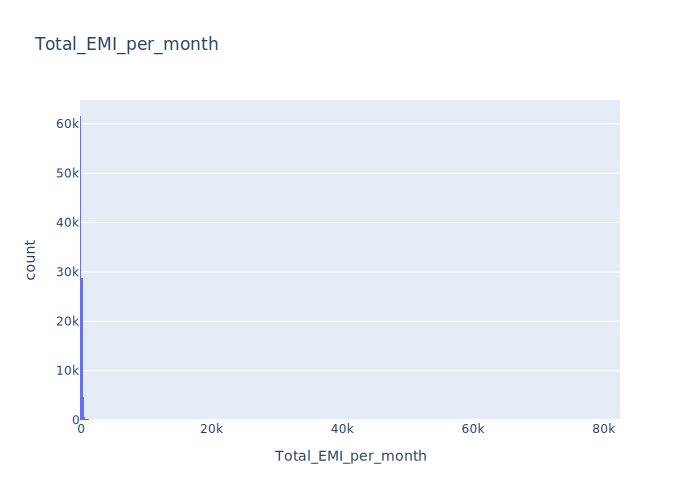

In [ ]:
fig = px.histogram(train_df, x="Total_EMI_per_month",title = "Total_EMI_per_month")
fig.show()


También se debe hacer una limpieza ya que hay valores muy altos que no tienen sentido. Al ser un rango de posibles valores tan grandes, no tiene mucho sentido reemplazar estos valores por la moda ya que todos los valores serán distintos. Sabemos que son pocos los datos que tienen este problema por lo que decidimos eliminarlos.

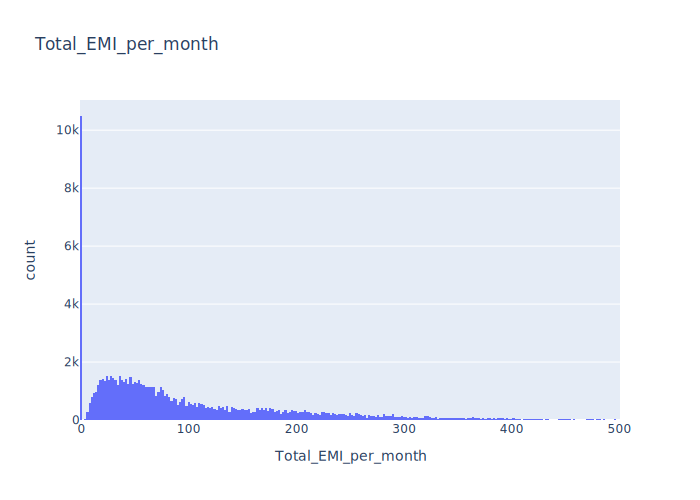

In [ ]:
train_df = train_df[(train_df.Total_EMI_per_month >=0) & (train_df.Total_EMI_per_month <= 500)]
fig = px.histogram(train_df, x="Total_EMI_per_month",title = "Total_EMI_per_month")
fig.show()

### Annual Income


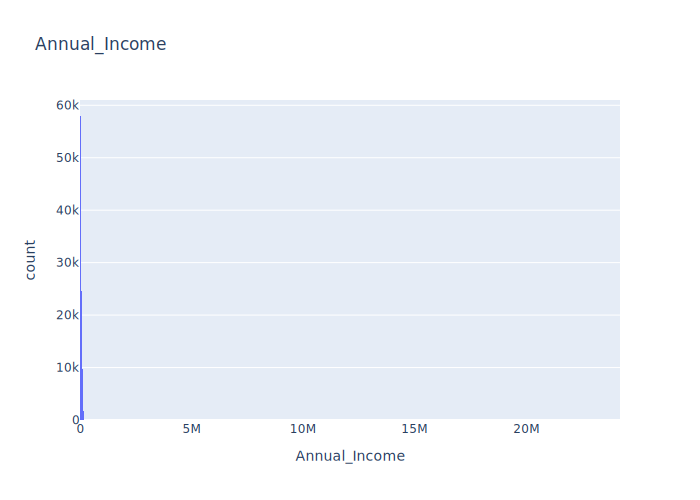

In [ ]:
fig = px.histogram(train_df, x="Annual_Income",title = "Annual_Income")
fig.show()

Vemos que hay valores demasiado altos por lo que debemos hacer una limpieza. En este caso pudimos haber utilizado la tecnica que hemos utilizado en varias variables pero al ser tan pocos también y al ser una variable con un rango tan elevado se considera que es mejor eliminarlas para no afectar tanto el desempeñod el modelo. 

In [ ]:
train_df[(train_df.Annual_Income > 200000)].shape

(944, 28)

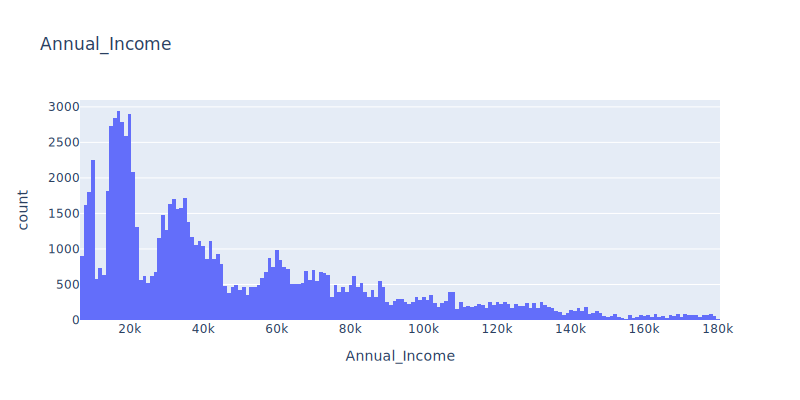

In [ ]:
train_df = train_df[(train_df.Annual_Income >=0) & (train_df.Annual_Income <= 200000)]
fig = px.histogram(train_df, x="Annual_Income",title = "Annual_Income",width=800, height=400)
fig.show()

La mayoria de personas se encuentra en la cola izquierda. A medida que aumentan  los salarios son menos las personas que se encuentran en ese rango

### Num_of_Loan

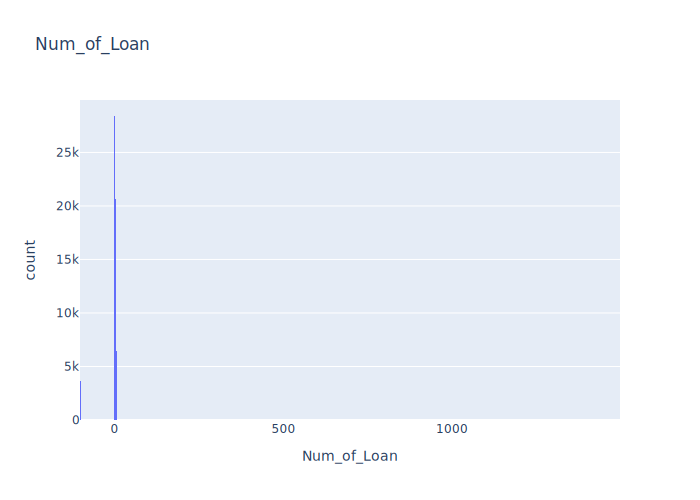

In [ ]:
fig = px.histogram(train_df, x="Num_of_Loan",title = "Num_of_Loan")
fig.show()

In [ ]:
def limpieza_num_prestamos(row):
  if (10 < row['Num_of_Loan']) or (0 > row['Num_of_Loan']):
      Num_of_Loan=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Num_of_Loan'].dropna()).mode()
      try:
          return Num_of_Loan[0]
      except:
          return np.NaN
  else:
      return row['Num_of_Loan']

In [ ]:
train_df['Num_of_Loan']=train_df.apply(limpieza_num_prestamos,axis=1)


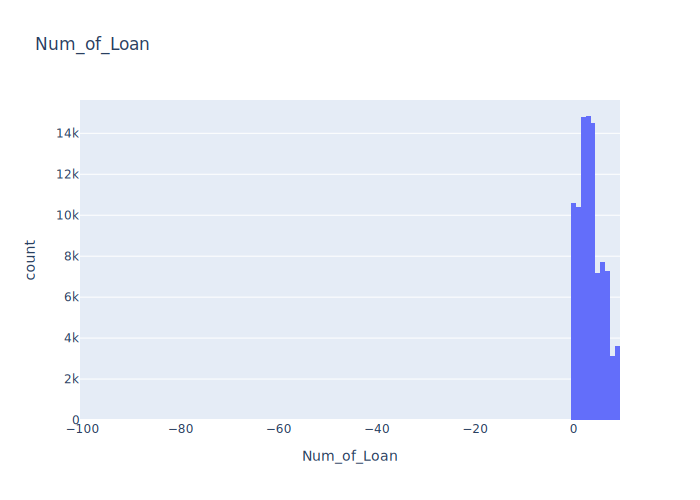

In [ ]:
fig = px.histogram(train_df, x="Num_of_Loan",title = "Num_of_Loan")
fig.show()

Al ver que hay uno que otro valor negativo se eliminan

In [ ]:
train_df = train_df[train_df.Num_of_Loan >= 0]

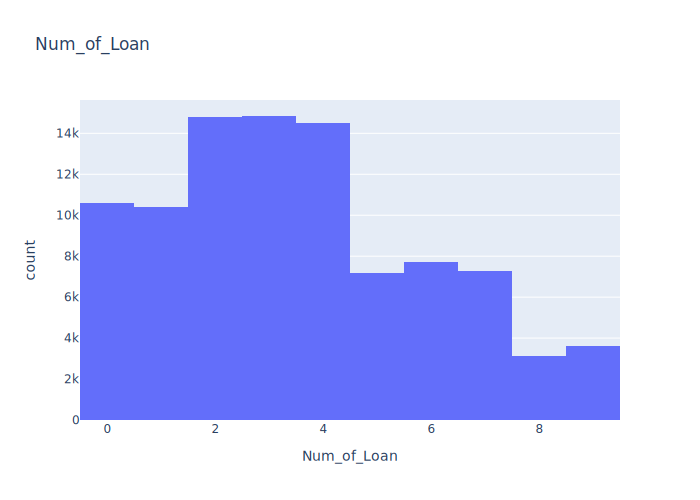

In [ ]:
fig = px.histogram(train_df, x="Num_of_Loan",title = "Num_of_Loan")
fig.show()

La mayoria de personas tienen entre 2 y 4 prestamos

### Num_of_Delayed_Payment

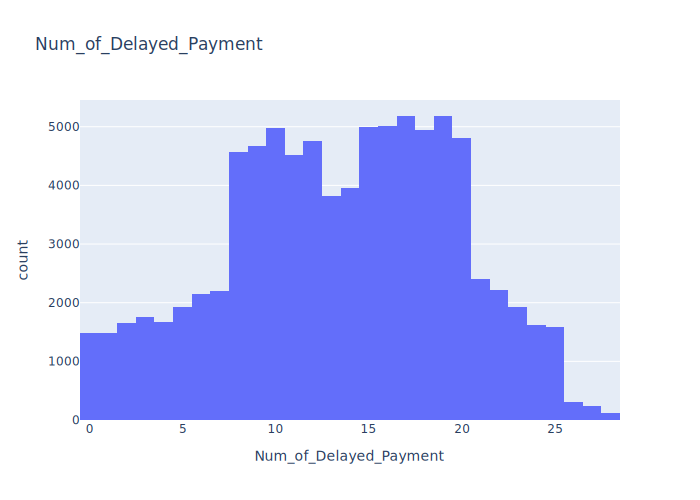

In [ ]:
train_df = train_df[(train_df.Num_of_Delayed_Payment >=0) & (train_df.Num_of_Delayed_Payment <= 29)]

fig = px.histogram(train_df, x="Num_of_Delayed_Payment",title = "Num_of_Delayed_Payment")
fig.show()

### Changed_Credit_Limit

También debemos cambiar el tipo de dato a float para poder visualizarlo correctamente

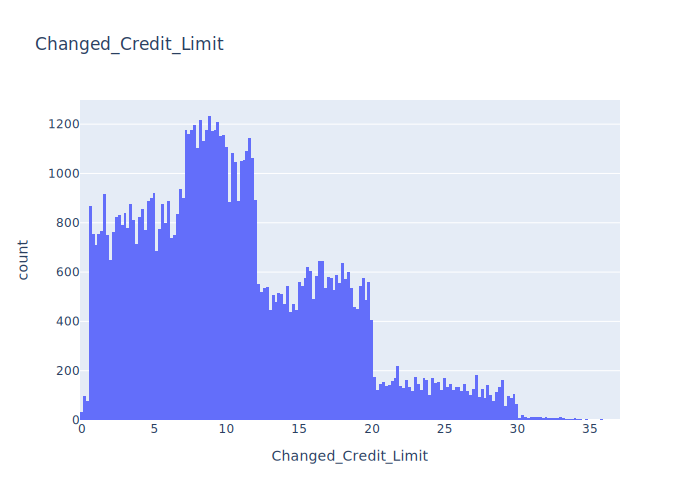

In [ ]:
train_df = train_df[(train_df.Changed_Credit_Limit >=0)]

fig = px.histogram(train_df, x="Changed_Credit_Limit",title = "Changed_Credit_Limit")
fig.show()

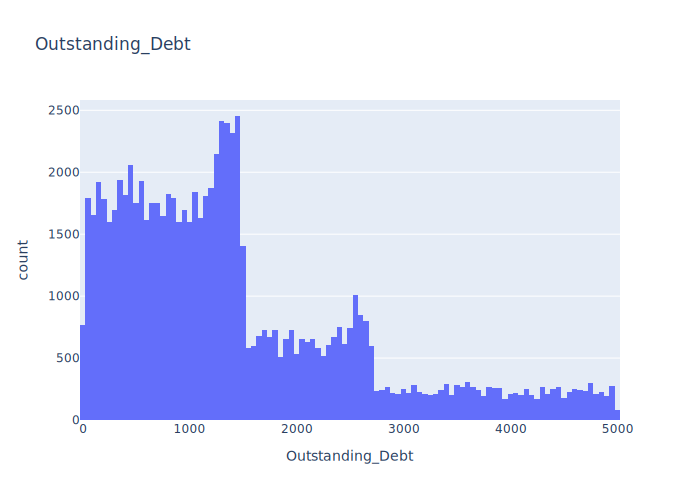

In [ ]:
fig = px.histogram(train_df, x="Outstanding_Debt",title = "Outstanding_Debt")
fig.show()

### Amount_invested_monthly

Se decide que para eliminar los outliers se van a tomar valores que esten por debajo de la media + 3 desviaciones estandar = 780.5650810000001. Antes rellenamos los NA con lo visto anteriormente. 

In [ ]:
def limpieza_mensual(row):
  if pd.isnull(row['Amount_invested_monthly']):
      Amount_invested_monthly=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Amount_invested_monthly'].dropna()).mode()
      try:
          return Amount_invested_monthly[0]
      except:
          return np.NaN
  else:
      return row['Amount_invested_monthly']

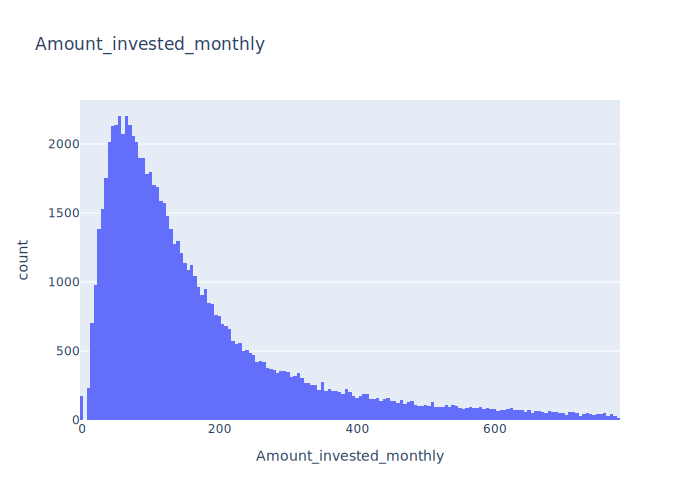

In [ ]:
train_df['Amount_invested_monthly']=train_df.apply(limpieza_mensual,axis=1)

train_df = train_df[(train_df.Amount_invested_monthly >=0) & (train_df.Amount_invested_monthly <= 780.5650810000001)]

fig = px.histogram(train_df, x="Amount_invested_monthly",title = "Amount_invested_monthly")
fig.show()


La mayoria de cantidad invertida se encuentra en la cola  izquierda y disminuye a medida que aumenta la cantidad. Parece ser una distribución exponencial

### Monthly_Balance

Se llenan los NAs y eliminan valores negativos.

In [ ]:
def limpieza_balance(row):
  if pd.isnull(row['Monthly_Balance']):
      Monthly_Balance=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Monthly_Balance'].dropna()).mode()
      try:
          return Monthly_Balance[0]
      except:
          return np.NaN
  else:
      return row['Monthly_Balance']
train_df['Monthly_Balance']=train_df.apply(limpieza_balance,axis=1)


In [ ]:
train_df[(train_df['Monthly_Balance'] <= 0)].shape

(8, 28)

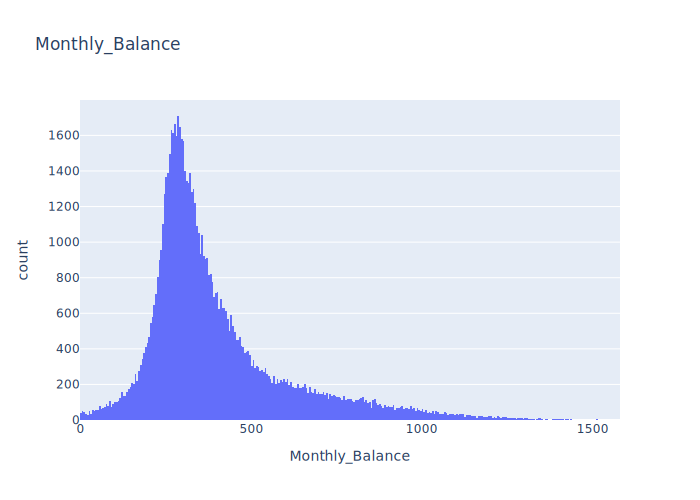

In [ ]:
train_df = train_df[(train_df.Monthly_Balance >=0)]
fig = px.histogram(train_df, x="Monthly_Balance",title = "Monthly_Balance")
fig.show()

### Monthly Inhand Salary

In [ ]:
def limpieza_salario(row):
  if pd.isnull(row['Monthly_Inhand_Salary']):
      Monthly_Inhand_Salary=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Monthly_Inhand_Salary'].dropna()).mode()
      try:
          return Monthly_Inhand_Salary[0]
      except:
          return np.NaN
  else:
      return row['Monthly_Inhand_Salary']
train_df['Monthly_Inhand_Salary']=train_df.apply(limpieza_salario,axis=1)

### Credit_History_Age

In [ ]:
def get_Credit_History_Age(row):
  if pd.isnull(row['Credit_History_Age']):
      Credit_History_Age=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Credit_History_Age'].dropna()).mode()
      try:
          return Credit_History_Age[0]
      except:
          return np.NaN
  else:
      return row['Credit_History_Age']
train_df['Credit_History_Age']=train_df.apply(get_Credit_History_Age,axis=1)

In [ ]:
train_df.shape

(77583, 28)

## Variables Categoricas

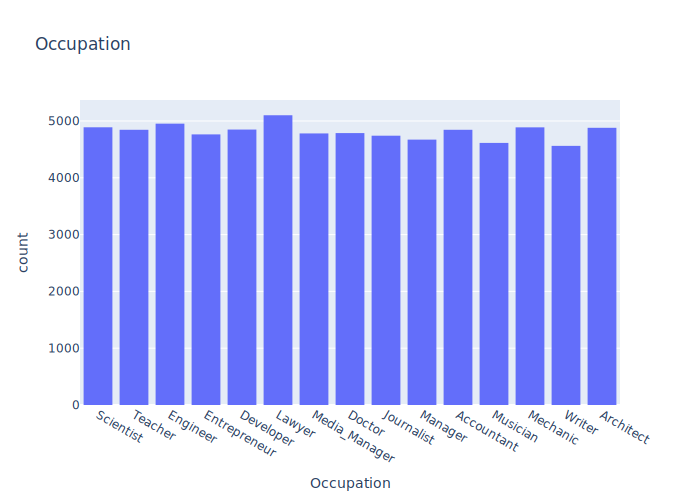

In [ ]:
fig = px.histogram(train_df, x="Occupation",title = "Occupation")
fig.show()

Las profesiones están distribuidas equitativamente en el dataset.
Lidiamos con los NAs.

In [ ]:
def limpieza_ocupacion(row):
  if pd.isnull(row['Occupation']):
      Occupation=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Occupation'].dropna()).mode()
      try:
          return Occupation[0]
      except:
          return np.NaN
  else:
      return row['Occupation']
train_df['Occupation']=train_df.apply(limpieza_ocupacion,axis=1)

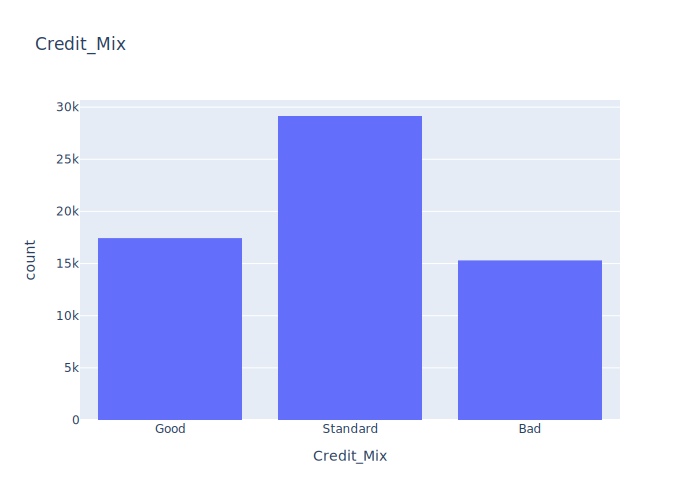

In [ ]:
fig = px.histogram(train_df, x="Credit_Mix",title = "Credit_Mix")
fig.show()

In [ ]:
def limpieza_credit_mix(row):
  if pd.isnull(row['Credit_Mix']):
      Credit_Mix=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Credit_Mix'].dropna()).mode()
      try:
          return Credit_Mix[0]
      except:
          return np.NaN
  else:
      return row['Credit_Mix']
train_df['Credit_Mix']=train_df.apply(limpieza_credit_mix,axis=1)


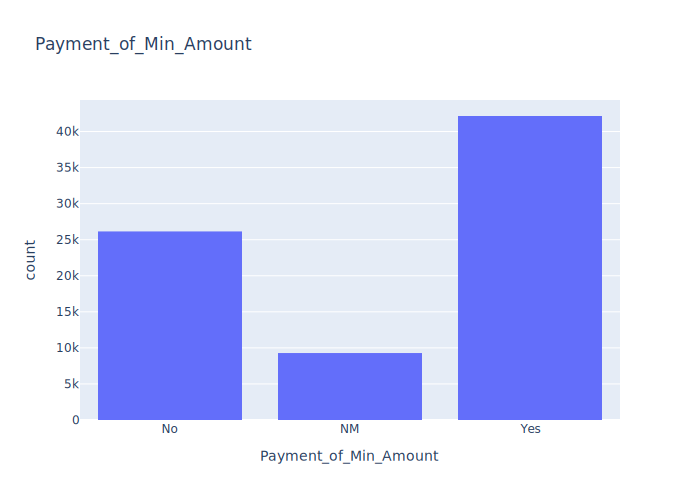

In [ ]:
fig = px.histogram(train_df, x="Payment_of_Min_Amount",title = "Payment_of_Min_Amount")
fig.show()

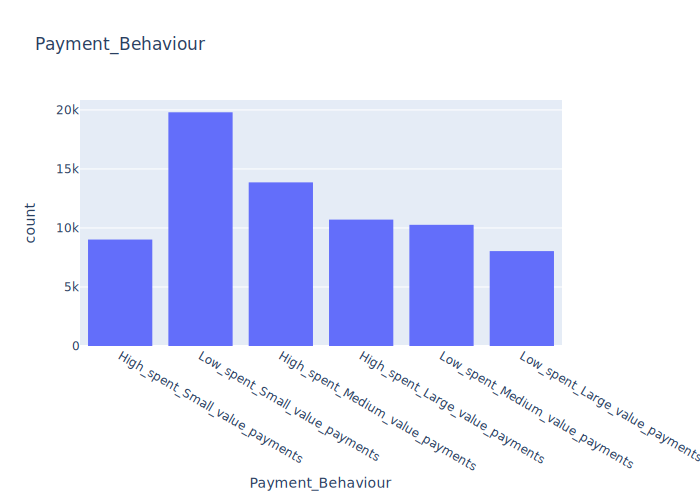

In [ ]:
fig = px.histogram(train_df, x="Payment_Behaviour",title = "Payment_Behaviour")
fig.show()

La mayoria de personas tienen gastos bajos y pagan valores bajos del credito

In [ ]:
def limpieza_comportamiento(row):
  if pd.isnull(row['Payment_Behaviour']):
      Payment_Behaviour=(train_df[train_df['Customer_ID']==row['Customer_ID']]['Payment_Behaviour'].dropna()).mode()
      try:
          return Payment_Behaviour[0]
      except:
          return np.NaN
  else:
      return row['Payment_Behaviour']
train_df['Payment_Behaviour']=train_df.apply(limpieza_comportamiento,axis=1)

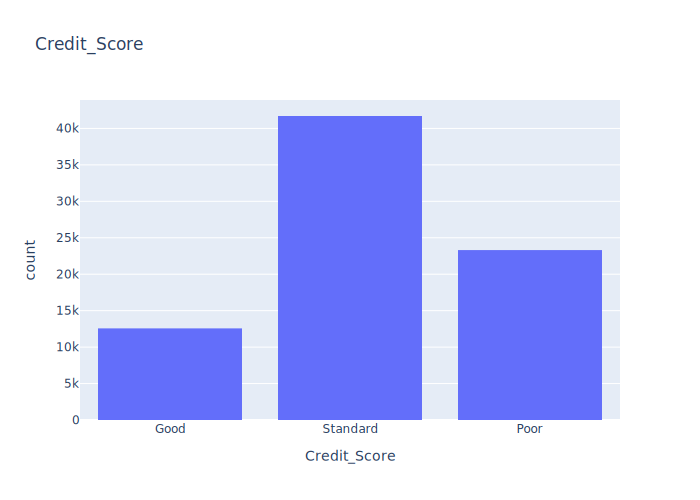

In [ ]:
fig = px.histogram(train_df, x="Credit_Score",title = "Credit_Score")
fig.show()

La mayoria de personas en el dataset tienen un puntaje estandar seguido de un mal puntaje y por último un buen puntaje

In [ ]:
#Columnas innecesarioas
train_df.drop(["Name","Customer_ID","ID","SSN","Type_of_Loan"],inplace = True, axis = 1)

In [ ]:
train_df.isna().sum()

Month                        0
Age                          0
Occupation                   4
Annual_Income                0
Monthly_Inhand_Salary       20
Num_Bank_Accounts            0
Num_Credit_Card              0
Interest_Rate                0
Num_of_Loan                  0
Delay_from_due_date          0
Num_of_Delayed_Payment       0
Changed_Credit_Limit         0
Num_Credit_Inquiries         0
Credit_Mix                  34
Outstanding_Debt             0
Credit_Utilization_Ratio     0
Credit_History_Age           9
Payment_of_Min_Amount        0
Total_EMI_per_month          0
Amount_invested_monthly      0
Payment_Behaviour           10
Monthly_Balance              0
Credit_Score                 0
dtype: int64

In [ ]:
train_df = train_df.dropna()

In [ ]:
# Se genera un nuevo archivo con los datos limpios ya que la limpieza es algo demorada
train_df.to_csv("train_clean.csv",index = False)

In [1]:
# Se cargan los datos limpios y se sigue con la preparacion de los datos
clean_df = pd.read_csv("train_clean.csv")

In [ ]:
clean_df = clean_df.dropna()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

meses_le = LabelEncoder()
clean_df["Month"] = meses_le.fit_transform(clean_df['Month']) + 1


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(enc.fit_transform(clean_df[["Occupation","Payment_of_Min_Amount","Payment_Behaviour"]] ).toarray(),columns = [item for sublist in enc.categories_ for item in sublist])
clean_df = clean_df.join(encoder_df)

In [ ]:
clean_df["Credit_Mix"] = clean_df["Credit_Mix"].replace({"Bad":0,"Standard":1,"Good":2})

In [ ]:
clean_df.drop(["Occupation","Payment_of_Min_Amount","Payment_Behaviour"],axis = 1, inplace = True)

In [ ]:
clean_df.head(10)

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Writer,NM,No,Yes,High_spent_Large_value_payments,High_spent_Medium_value_payments,High_spent_Small_value_payments,Low_spent_Large_value_payments,Low_spent_Medium_value_payments,Low_spent_Small_value_payments
0,4,23,19114.12,1824.843333,3,4,3,4,3,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,23,19114.12,1824.843333,3,4,3,4,5,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6,23,19114.12,1824.843333,3,4,3,4,8,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5,23,19114.12,1824.843333,3,4,3,4,3,8.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,23,19114.12,1824.843333,3,4,3,4,3,6.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,4,28,34847.84,3037.986667,2,4,6,1,3,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,3,28,34847.84,3037.986667,2,4,6,1,7,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1,28,34847.84,3037.986667,2,4,6,1,3,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,8,28,34847.84,3037.986667,2,4,6,1,3,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,6,28,34847.84,3037.986667,2,4,6,1,3,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = clean_df.drop('Credit_Score',axis=1)
y = clean_df['Credit_Score']

print(X.shape)

(30968, 43)


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.3,random_state = 1234)

print(X_train.shape)
print(X_val.shape)

(21677, 43)
(9291, 43)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54259 entries, 74736 to 58067
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Month                             54259 non-null  int64  
 1   Age                               54259 non-null  int64  
 2   Annual_Income                     54259 non-null  float64
 3   Monthly_Inhand_Salary             54259 non-null  float64
 4   Num_Bank_Accounts                 54259 non-null  int64  
 5   Num_Credit_Card                   54259 non-null  int64  
 6   Interest_Rate                     54259 non-null  int64  
 7   Num_of_Loan                       54259 non-null  int64  
 8   Delay_from_due_date               54259 non-null  int64  
 9   Num_of_Delayed_Payment            54259 non-null  float64
 10  Changed_Credit_Limit              54259 non-null  float64
 11  Num_Credit_Inquiries              54259 non-null  float64
 12  

In [ ]:
y_train

74736        Poor
34580        Poor
10069        Poor
178          Good
49191        Poor
           ...   
55985    Standard
32399        Good
60620        Poor
34086    Standard
58067    Standard
Name: Credit_Score, Length: 54259, dtype: object

## Modelado

### Modelo 1. KKN

Estandarización de los datos

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
knn.fit(X_train_transformed , y_train)

KNeighborsClassifier()

In [ ]:
# Predicciones en train
predictions = knn.predict(X_train_transformed)
print("Confusion Matrix:")
print(confusion_matrix(y_train, predictions))
print()
print("Classification Report")
print(classification_report(y_train, predictions))

Confusion Matrix:
[[2418  152  857]
 [ 436 4986 1286]
 [ 893 1353 9296]]

Classification Report
              precision    recall  f1-score   support

        Good       0.65      0.71      0.67      3427
        Poor       0.77      0.74      0.76      6708
    Standard       0.81      0.81      0.81     11542

    accuracy                           0.77     21677
   macro avg       0.74      0.75      0.75     21677
weighted avg       0.77      0.77      0.77     21677



In [ ]:
X_val_transformed = scaler.transform(X_val)

In [ ]:
# Predicciones en test
predictions = knn.predict(X_val_transformed)
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))
print()
print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[ 844  118  564]
 [ 203 1670  871]
 [ 633  820 3568]]

Classification Report
              precision    recall  f1-score   support

        Good       0.50      0.55      0.53      1526
        Poor       0.64      0.61      0.62      2744
    Standard       0.71      0.71      0.71      5021

    accuracy                           0.65      9291
   macro avg       0.62      0.62      0.62      9291
weighted avg       0.66      0.65      0.66      9291



### Ajuste de hiperparametros de KNN

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# A sample parameter
parameters = {
    "n_neighbors":[3, 5, 10],
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(KNeighborsClassifier(), parameters,scoring='f1',refit=True,cv=3, n_jobs=-1)

clf.fit(X_train, y_train)
#converting the clf.cv_results to dataframe
print(clf.best_params_)


predictions = clf.predict(X_train)
print("Confusion Matrix:")
print(confusion_matrix(y_train, predictions))
print()
print("Classification Report")
print(classification_report(y_train, predictions))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning:

One or more of the test scores are non-finite: [nan nan nan]



{'n_neighbors': 3}
Confusion Matrix:
[[ 7321    54  1373]
 [  193 14548  1526]
 [ 1532  2302 25410]]

Classification Report
              precision    recall  f1-score   support

        Good       0.81      0.84      0.82      8748
        Poor       0.86      0.89      0.88     16267
    Standard       0.90      0.87      0.88     29244

    accuracy                           0.87     54259
   macro avg       0.86      0.87      0.86     54259
weighted avg       0.87      0.87      0.87     54259



In [ ]:
predictions = clf.predict(X_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))
print()
print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[2441   90 1270]
 [ 181 5361 1484]
 [1231 1647 9550]]

Classification Report
              precision    recall  f1-score   support

        Good       0.63      0.64      0.64      3801
        Poor       0.76      0.76      0.76      7026
    Standard       0.78      0.77      0.77     12428

    accuracy                           0.75     23255
   macro avg       0.72      0.72      0.72     23255
weighted avg       0.75      0.75      0.75     23255



### Modelo 2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(max_features=15 , max_depth=12)
rf.fit(X_train , y_train)

RandomForestClassifier(max_depth=12, max_features=15)

In [ ]:
rf_score_train=rf.score(X_train , y_train)
rf_score_train

0.7961997088040693

In [ ]:
rf_score_test=rf.score(X_val , y_val)
rf_score_test

0.7537303805633198

In [ ]:
# Predicciones en train
predictions = rf.predict(X_train)
print("Confusion Matrix:")
print(confusion_matrix(y_train, predictions))
print()
print("Classification Report")
print(classification_report(y_train, predictions))

Confusion Matrix:
[[ 6673    90  1985]
 [  795 12461  3011]
 [ 2364  2813 24067]]

Classification Report
              precision    recall  f1-score   support

        Good       0.68      0.76      0.72      8748
        Poor       0.81      0.77      0.79     16267
    Standard       0.83      0.82      0.83     29244

    accuracy                           0.80     54259
   macro avg       0.77      0.78      0.78     54259
weighted avg       0.80      0.80      0.80     54259



In [ ]:
predictions = rf.predict(X_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))
print()
print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[2748   75  978]
 [ 372 5042 1612]
 [1243 1447 9738]]

Classification Report
              precision    recall  f1-score   support

        Good       0.63      0.72      0.67      3801
        Poor       0.77      0.72      0.74      7026
    Standard       0.79      0.78      0.79     12428

    accuracy                           0.75     23255
   macro avg       0.73      0.74      0.73     23255
weighted avg       0.76      0.75      0.75     23255



## Ajuste de hiperparametros de RandomForest

In [ ]:

with tf.device('/device:GPU:0'):
  # A sample parameter
  parameters = {
      "max_features":[10, 15, 20, 25],
      "max_depth":[7, 12, 15, 20]
      }
  #passing the scoring function in the GridSearchCV
  clf = GridSearchCV(RandomForestClassifier(), parameters,refit=True,cv=3, n_jobs=-1)

  clf.fit(X_train, y_train)
  #converting the clf.cv_results to dataframe
  print(clf.best_params_)


  predictions = clf.predict(X_train)
  print("Confusion Matrix:")
  print(confusion_matrix(y_train, predictions))
  print()
  print("Classification Report")
  print(classification_report(y_train, predictions))

{'max_depth': 20, 'max_features': 25}
Confusion Matrix:
[[ 7965     1   782]
 [   62 15304   901]
 [  187   405 28652]]

Classification Report
              precision    recall  f1-score   support

        Good       0.97      0.91      0.94      8748
        Poor       0.97      0.94      0.96     16267
    Standard       0.94      0.98      0.96     29244

    accuracy                           0.96     54259
   macro avg       0.96      0.94      0.95     54259
weighted avg       0.96      0.96      0.96     54259



In [ ]:
predictions = clf.predict(X_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))
print()
print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[ 2867    30   904]
 [  109  5690  1227]
 [  854  1511 10063]]

Classification Report
              precision    recall  f1-score   support

        Good       0.75      0.75      0.75      3801
        Poor       0.79      0.81      0.80      7026
    Standard       0.83      0.81      0.82     12428

    accuracy                           0.80     23255
   macro avg       0.79      0.79      0.79     23255
weighted avg       0.80      0.80      0.80     23255



## Modelo 3. Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.75 , max_depth=12, n_estimators=50)
gb.fit(X_train , y_train)

GradientBoostingClassifier(learning_rate=0.75, max_depth=12, n_estimators=50)

In [ ]:
# Predicciones en train
predictions = gb.predict(X_train)
print("Confusion Matrix:")
print(confusion_matrix(y_train, predictions))
print()
print("Classification Report")
print(classification_report(y_train, predictions))

Confusion Matrix:
[[ 8748     0     0]
 [    0 16267     0]
 [    0     0 29244]]

Classification Report
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      8748
        Poor       1.00      1.00      1.00     16267
    Standard       1.00      1.00      1.00     29244

    accuracy                           1.00     54259
   macro avg       1.00      1.00      1.00     54259
weighted avg       1.00      1.00      1.00     54259



In [ ]:
predictions = gb.predict(X_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))
print()
print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[ 2749    32  1020]
 [   69  5545  1412]
 [  799  1481 10148]]

Classification Report
              precision    recall  f1-score   support

        Good       0.76      0.72      0.74      3801
        Poor       0.79      0.79      0.79      7026
    Standard       0.81      0.82      0.81     12428

    accuracy                           0.79     23255
   macro avg       0.78      0.78      0.78     23255
weighted avg       0.79      0.79      0.79     23255



### Ajuste de hiperparametros en Gradient Boosting

In [ ]:
with tf.device('/device:GPU:0'): 
    # A sample parameter
    parameters = {
        "learning_rate": [0.75, 1],
        "max_depth":[5, 10, 12],
        }
    #passing the scoring function in the GridSearchCV
    clf = GridSearchCV(GradientBoostingClassifier(n_estimators=50), parameters,scoring='f1',refit=True,cv=3, n_jobs=-1)

    clf.fit(X_train, y_train)
    #converting the clf.cv_results to dataframe
    print(clf.best_params_)


    predictions = clf.predict(X_train)
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, predictions))
    print()
    print("Classification Report")
    print(classification_report(y_train, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan]



{'learning_rate': 0.75, 'max_depth': 5}
Confusion Matrix:
[[ 7034   104  1610]
 [  384 13300  2583]
 [ 1417  2605 25222]]

Classification Report
              precision    recall  f1-score   support

        Good       0.80      0.80      0.80      8748
        Poor       0.83      0.82      0.82     16267
    Standard       0.86      0.86      0.86     29244

    accuracy                           0.84     54259
   macro avg       0.83      0.83      0.83     54259
weighted avg       0.84      0.84      0.84     54259



In [ ]:
predictions = clf.predict(X_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))
print()
print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[2585   74 1142]
 [ 266 5202 1558]
 [ 932 1558 9938]]

Classification Report
              precision    recall  f1-score   support

        Good       0.68      0.68      0.68      3801
        Poor       0.76      0.74      0.75      7026
    Standard       0.79      0.80      0.79     12428

    accuracy                           0.76     23255
   macro avg       0.74      0.74      0.74     23255
weighted avg       0.76      0.76      0.76     23255



## Mejor modelo
El mejor modelo teniendo en cuenta aspectos como que tenga menos overfitting, y un buen comportamiento tanto en train como en test fue el Random Forest original, entrenado con max_features=15 , max_depth=12

### Desempeño en Train

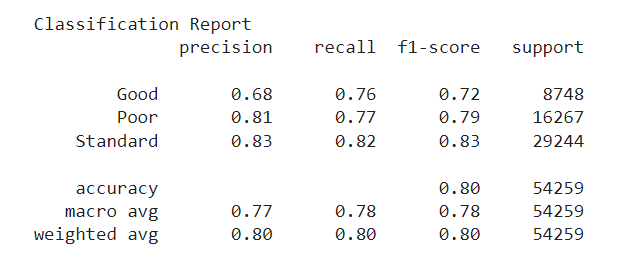

### Desempeño en Test
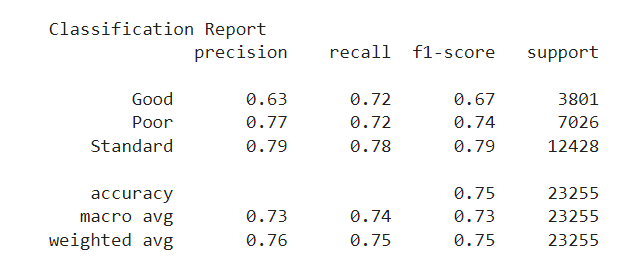

### Conclusiones

*   Como vimos en la etapa de limpieza, la calidad de los datos es muy baja. Hay muchos datos faltantes y demasiados datos con valores no permitidos. Los datos deben estar en mejores condiciones para que no se hagan tantos supuestos en la limpieza y se pueda obtener un mejor desempeño con datos reales. 
*   También se podrían reducir los tipos de préstamo ya que actualmente son demasiados, pero es una característica importante para predecir. Se podría pensar en características adicionales como si alguna vez fue reportado en una central de riesgo. 
*   Por último, sería ideal tener más datos de las clases Good y Poor porque se cuenta con muy pocos datos, lo que genera un desbalanceo. Esto hace que nuestro modelo no se desempeñe de la mejor forma en estas clases. Consideramos que el modelo obtenido es un buen modelo para poner en producción ya que las métricas dan resultados favorables, sin embargo, se debería validar con el negocio para ver si el porcentaje de error es aceptable para ellos. Este modelo podría ponerse en producción por medio de un API REST que se conecte a una aplicación web.

